In [2]:
# Imports and configuration
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

# Optional: LightGBM
try:
    from lightgbm import LGBMClassifier
    LGBM_AVAILABLE = True
except Exception:
    LGBM_AVAILABLE = False
    print('LightGBM not found. Install lightgbm to include it in the ensemble.')

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Saving
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [3]:
# Load dataset and basic checks
csv_path = 'breast_cancer.csv'
assert os.path.exists(csv_path), 'breast_cancer.csv not found in project root.'

df = pd.read_csv(csv_path)
print('Original shape:', df.shape)
print(df.head())
print(df.info())

# Drop non-informative identifiers if present
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Encode target: diagnosis (M=1, B=0)
assert 'diagnosis' in df.columns, 'Expected target column "diagnosis" not found.'
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0}).astype(int)

# Handle missing values (median for numeric)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

print('Post-clean shape:', df.shape)
df.head()


Original shape: (569, 32)
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst 

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


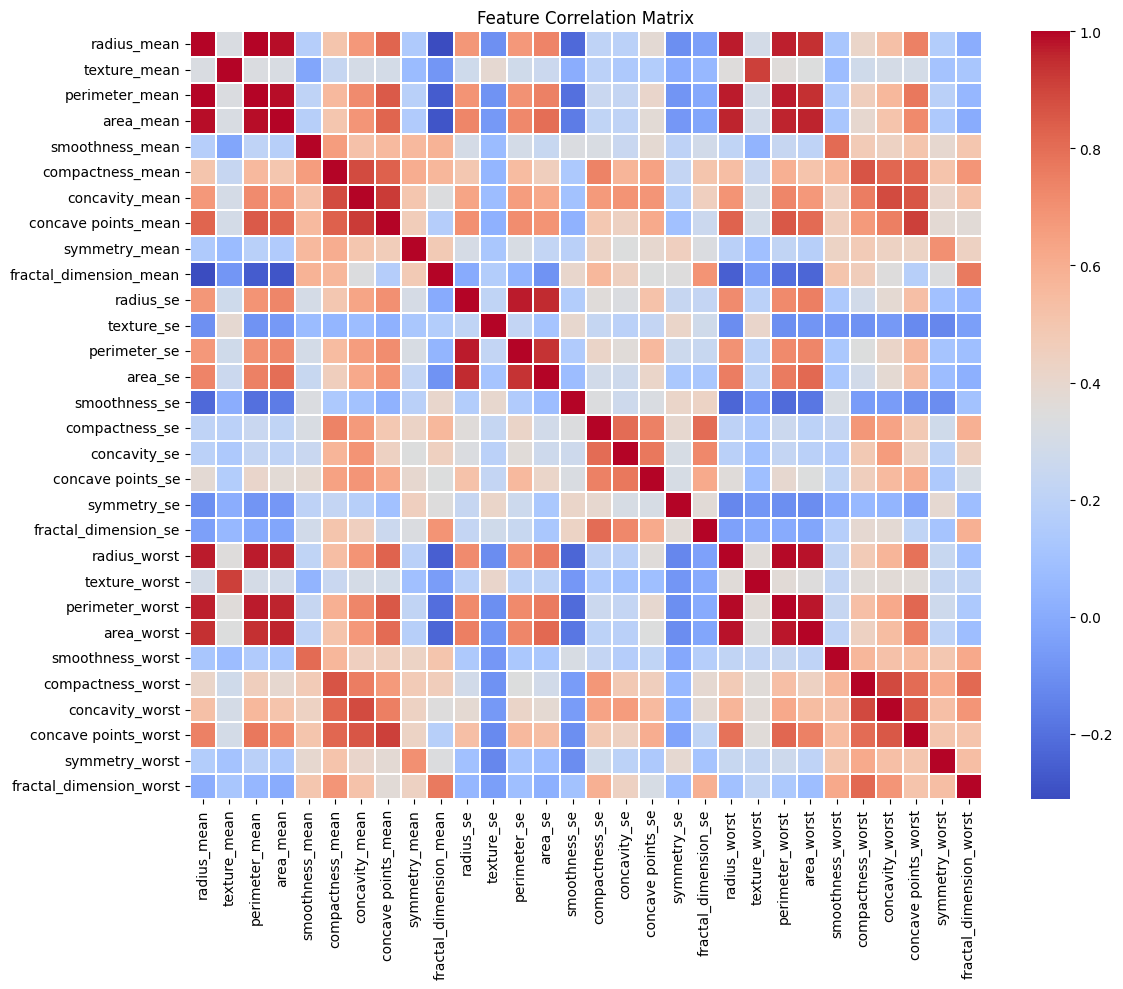

In [4]:
# Correlation matrix heatmap (numeric features only)
plt.figure(figsize=(12, 10))
num_df = df.drop(columns=['diagnosis']).select_dtypes(include=[np.number])
corr = num_df.corr()
sns.heatmap(corr, cmap='coolwarm', linewidths=0.3)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


In [5]:
# Train/test split, scaling, and SMOTE on training set
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train class distribution (after SMOTE):', np.bincount(y_train_bal))


Train shape: (455, 30) Test shape: (114, 30)
Train class distribution (after SMOTE): [285 285]


In [6]:
# Helper: evaluation with confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    acc = accuracy_score(yte, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')
    print(classification_report(yte, y_pred, target_names=['Benign(0)', 'Malignant(1)']))
    cm = confusion_matrix(yte, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Malignant']).plot(cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()
    return acc


Extra Trees Accuracy: 0.9825
              precision    recall  f1-score   support

   Benign(0)       0.97      1.00      0.99        72
Malignant(1)       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



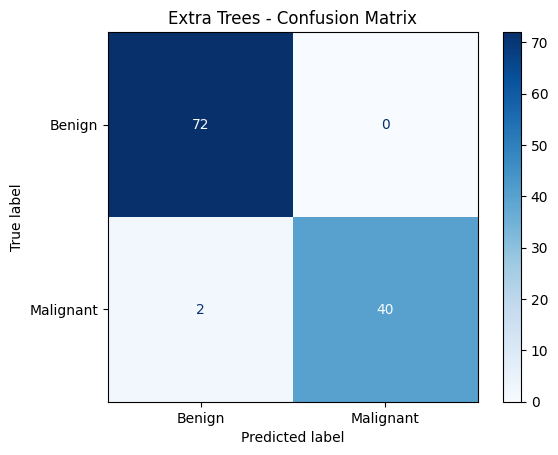

Ridge Classifier Accuracy: 0.9825
              precision    recall  f1-score   support

   Benign(0)       0.97      1.00      0.99        72
Malignant(1)       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



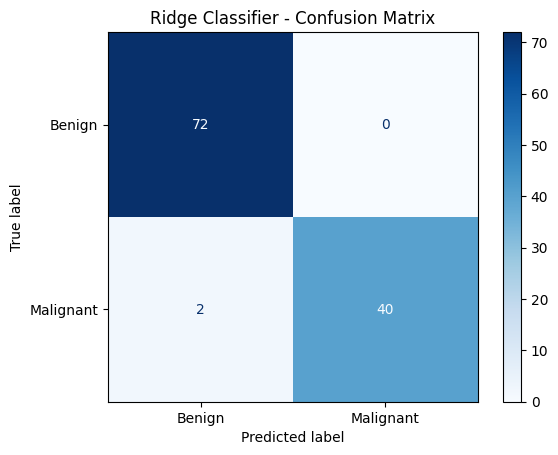

LDA Accuracy: 0.9825
              precision    recall  f1-score   support

   Benign(0)       0.97      1.00      0.99        72
Malignant(1)       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



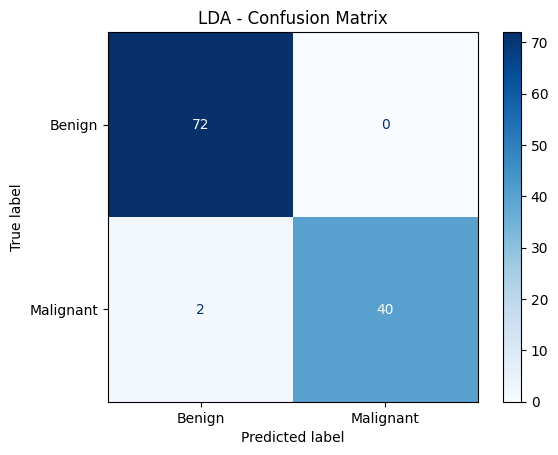

[LightGBM] [Info] Number of positive: 285, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5709
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

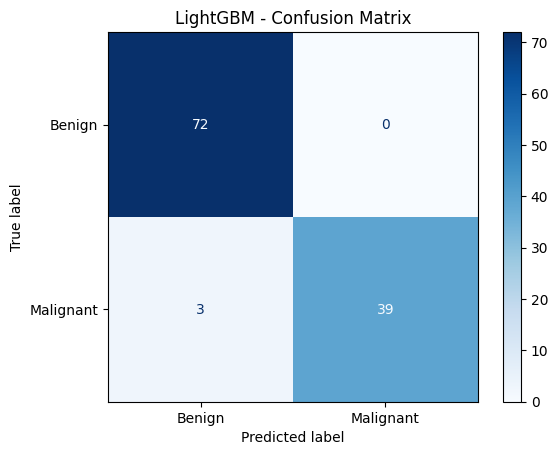

{'Extra Trees': 0.9824561403508771,
 'Ridge Classifier': 0.9824561403508771,
 'LDA': 0.9824561403508771,
 'LightGBM': 0.9736842105263158}

In [7]:
# Train the four requested classifiers
results = {}

etc = ExtraTreesClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight='balanced')
rc = RidgeClassifier(random_state=RANDOM_STATE)
lda = LinearDiscriminantAnalysis()

if LGBM_AVAILABLE:
    lgbm = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')
else:
    lgbm = None

print('='*80)
results['Extra Trees'] = evaluate('Extra Trees', etc, X_train_bal, y_train_bal, X_test_scaled, y_test)
print('='*80)
results['Ridge Classifier'] = evaluate('Ridge Classifier', rc, X_train_bal, y_train_bal, X_test_scaled, y_test)
print('='*80)
results['LDA'] = evaluate('LDA', lda, X_train_bal, y_train_bal, X_test_scaled, y_test)

if lgbm is not None:
    print('='*80)
    results['LightGBM'] = evaluate('LightGBM', lgbm, X_train_bal, y_train_bal, X_test_scaled, y_test)
else:
    print('Skipping LightGBM (not installed).')

results


[LightGBM] [Info] Number of positive: 285, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5709
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

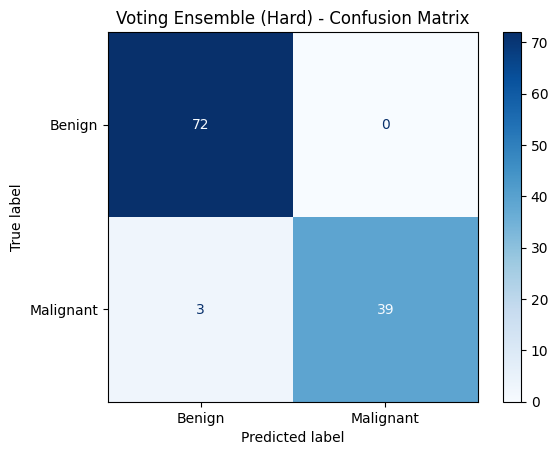


Accuracies:
Extra Trees: 0.9825
Ridge Classifier: 0.9825
LDA: 0.9825
LightGBM: 0.9737
Voting (Hard): 0.9737


In [8]:
# Voting Ensemble (hard voting across the four models)
estimators = [('etc', etc), ('rc', rc), ('lda', lda)]
if lgbm is not None:
    estimators.append(('lgbm', lgbm))

voting = VotingClassifier(estimators=estimators, voting='hard')
print('='*80)
ensemble_acc = evaluate('Voting Ensemble (Hard)', voting, X_train_bal, y_train_bal, X_test_scaled, y_test)

results['Voting (Hard)'] = ensemble_acc

sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print('\nAccuracies:')
for k, v in sorted_results:
    print(f'{k}: {v:.4f}')


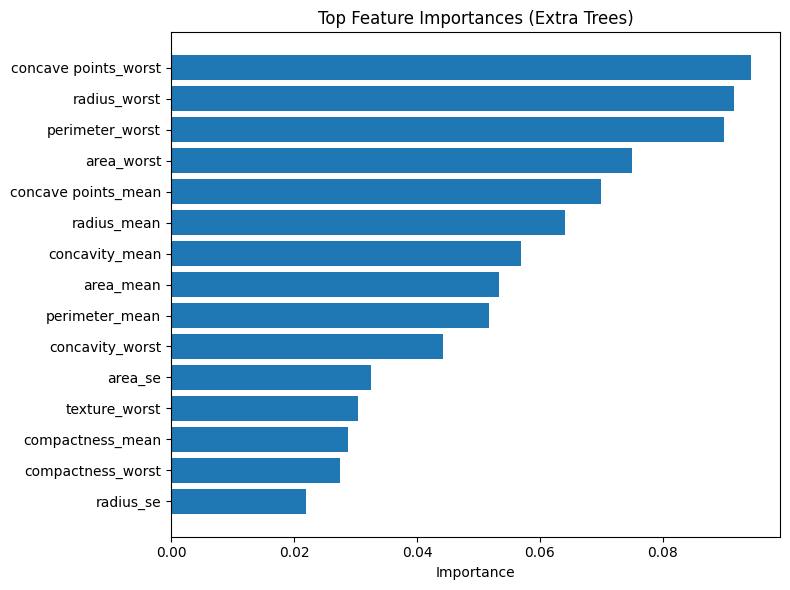

In [9]:
# Feature importances from Extra Trees
if hasattr(etc, 'feature_importances_'):
    importances = etc.fit(X_train_bal, y_train_bal).feature_importances_
    indices = np.argsort(importances)[::-1]
    top_k = 15
    top_indices = indices[:top_k]

    plt.figure(figsize=(8, 6))
    plt.barh(range(top_k), importances[top_indices][::-1])
    plt.yticks(range(top_k), np.array(X.columns)[top_indices][::-1])
    plt.xlabel('Importance')
    plt.title('Top Feature Importances (Extra Trees)')
    plt.tight_layout()
    plt.show()
else:
    print('Extra Trees has no feature_importances_.')


In [10]:
# Save the best model and the scaler
best_name, best_acc = max(results.items(), key=lambda x: x[1])
print(f'Best model: {best_name} with accuracy {best_acc:.4f}')

# Map names to model constructors for clean refit
constructors = {
    'Extra Trees': lambda: ExtraTreesClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight='balanced'),
    'Ridge Classifier': lambda: RidgeClassifier(random_state=RANDOM_STATE),
    'LDA': lambda: LinearDiscriminantAnalysis(),
}
if lgbm is not None:
    constructors['LightGBM'] = lambda: LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')
constructors['Voting (Hard)'] = lambda: VotingClassifier(estimators=[
    ('etc', ExtraTreesClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight='balanced')),
    ('rc', RidgeClassifier(random_state=RANDOM_STATE)),
    ('lda', LinearDiscriminantAnalysis()),
] + (([('lgbm', LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced'))]) if lgbm is not None else []), voting='hard')

best_model = constructors[best_name]()
best_model.fit(X_train_bal, y_train_bal)

joblib.dump(best_model, 'best_model_ensemble.joblib')
joblib.dump(scaler, 'scaler.joblib')
print('Saved best_model_ensemble.joblib and scaler.joblib')


Best model: Extra Trees with accuracy 0.9825
Saved best_model_ensemble.joblib and scaler.joblib
